In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix
import joblib

In [14]:
# Load the datasets
cross_sectional_df = pd.read_csv('/content/oasis_cross-sectional.csv')
longitudinal_df = pd.read_csv('/content/oasis_longitudinal.csv')

df = longitudinal_df
df.shape


(373, 15)

In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


Basic Data Pre-processing

In [16]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [17]:
# Handle missing values
df = df.dropna()

categorical_columns = ['Group', 'M/F', 'Subject ID']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


# Drop irrelevant columns if they exist
columns_to_drop = ['MRI ID', 'Hand']
df.drop(columns_to_drop, axis=1, inplace=True)

<ipython-input-17-c64e93b72bb7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
<ipython-input-17-c64e93b72bb7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
<ipython-input-17-c64e93b72bb7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [19]:
df.isnull().sum()

Subject ID    0
Group         0
Visit         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

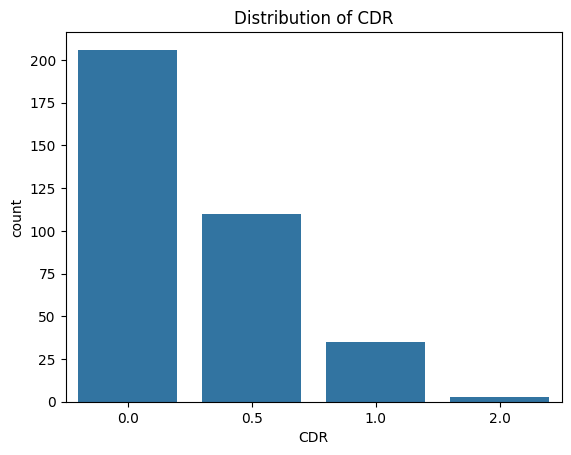

In [20]:
# EDA: Visualization
# Plot distribution of target variable 'CDR'
sns.countplot(x='CDR', data=df)
plt.title('Distribution of CDR')
plt.show()

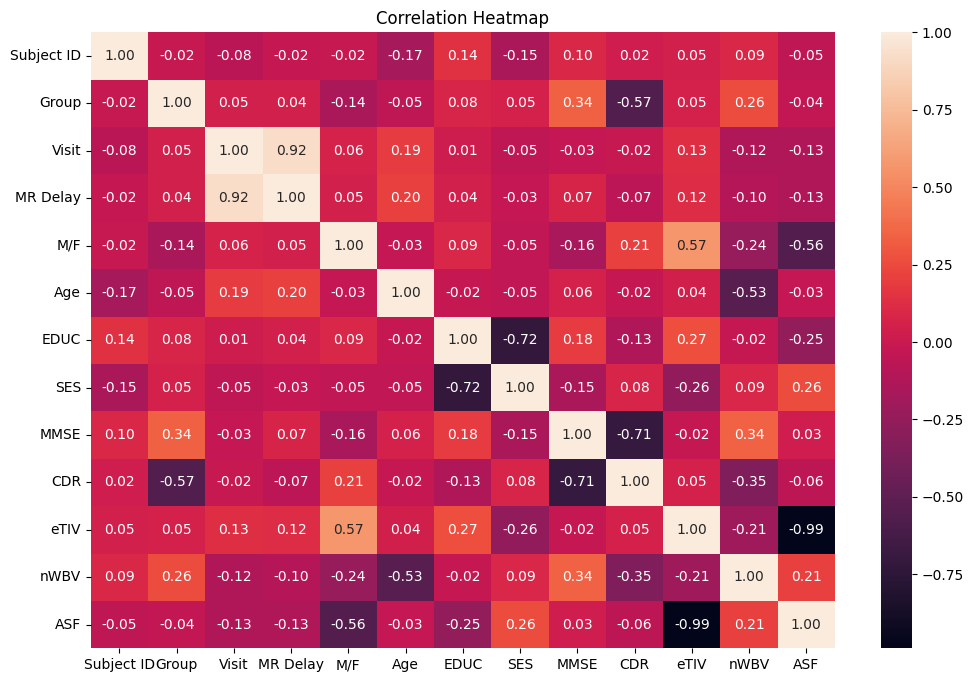

In [22]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Check for non-numeric columns
print("Columns with non-numeric data:\n", df.select_dtypes(include=['object']).columns)



Columns with non-numeric data:
 Index(['Subject ID', 'MRI ID', 'Group', 'M/F', 'Hand', 'ID'], dtype='object')


In [23]:
# Define features and target
X = df.drop('CDR', axis=1)  # Assuming 'CDR' is the target variable
y = df['CDR']

# Convert target variable to binary (dementia vs. no dementia)
# Assuming CDR 0.5 and above as dementia, 0 as no dementia
y = (y > 0).astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "GradientBoostingClassifier" : GradientBoostingClassifier(random_state=42),
    "MLPClassifier" : MLPClassifier(random_state=42, max_iter=500)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print(classification_report(y_test, y_pred))

Model: RandomForest
Accuracy: 0.971830985915493
ROC AUC: 0.9887096774193549
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.94      0.97        31

    accuracy                           0.97        71
   macro avg       0.98      0.97      0.97        71
weighted avg       0.97      0.97      0.97        71



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Model: LogisticRegression
Accuracy: 0.8591549295774648
ROC AUC: 0.9370967741935483
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.84      0.84      0.84        31

    accuracy                           0.86        71
   macro avg       0.86      0.86      0.86        71
weighted avg       0.86      0.86      0.86        71

Model: SVM
Accuracy: 0.5633802816901409
ROC AUC: 0.3991935483870968
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        40
           1       0.00      0.00      0.00        31

    accuracy                           0.56        71
   macro avg       0.28      0.50      0.36        71
weighted avg       0.32      0.56      0.41        71

Model: GradientBoostingClassifier
Accuracy: 0.971830985915493
ROC AUC: 0.989516129032258
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        

In [36]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
name = "GradientBoostingClassifier"
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

print(f"Model: {name}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(classification_report(y_test, y_pred))

Model: GradientBoostingClassifier
Accuracy: 0.971830985915493
ROC AUC: 0.989516129032258
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.97      0.97      0.97        31

    accuracy                           0.97        71
   macro avg       0.97      0.97      0.97        71
weighted avg       0.97      0.97      0.97        71



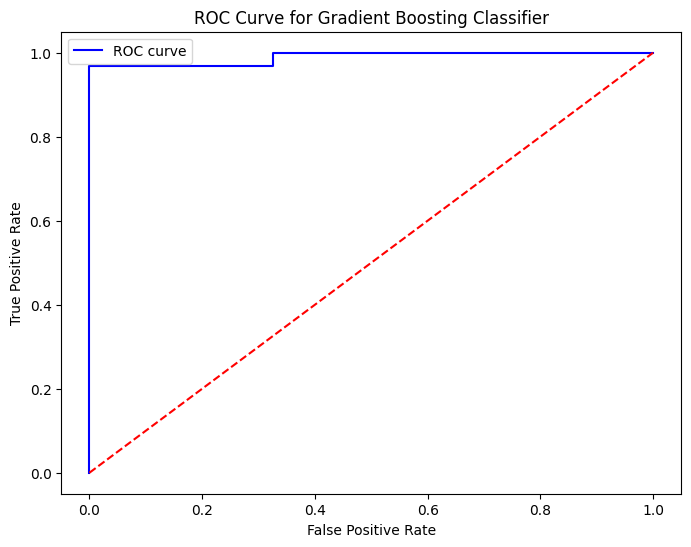

In [38]:
# Predict probabilities for Logistic Regression
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend()
plt.show()

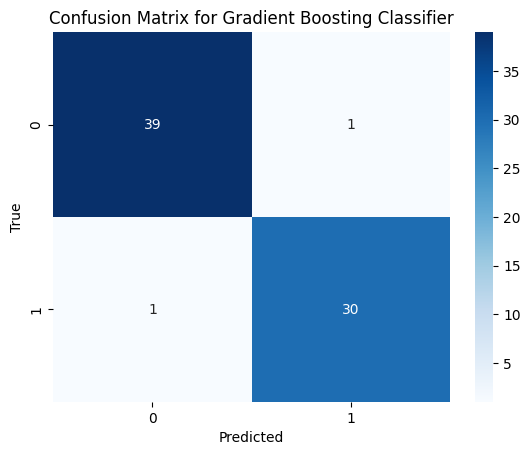

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()